# Exemple of pipeline PCA-GP-PCA type

In [43]:
import numpy as np
import matplotlib.pyplot as plt

In [44]:
from sklearn.datasets import make_regression

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor

In [45]:
from plaid.containers.dataset import Dataset
from plaid.containers.sample import Sample
from plaid.problem_definition import ProblemDefinition
from plaid.wrappers.sklearn import WrappedSklearnTransform, WrappedSklearnRegressor

## Generate some synthetic regression data

In [46]:
NB_SAMPLES = 103
NB_INPUT_SCALARS = 3
NB_OUTPUT_SCALARS = 5
FIELD_SIZE = 17

X, y = make_regression(n_samples=NB_SAMPLES, n_features=NB_INPUT_SCALARS, n_targets=NB_OUTPUT_SCALARS + FIELD_SIZE, noise=0.1)

In [47]:
dset = Dataset()
samples = []
for sample_id in range(NB_SAMPLES):
    sample = Sample()
    for scalar_id in range(NB_INPUT_SCALARS):
        sample.add_scalar(f"input_scalar_{scalar_id}", X[sample_id, scalar_id])
    for scalar_id in range(NB_OUTPUT_SCALARS):
        sample.add_scalar(f"output_scalar_{scalar_id}", y[sample_id, scalar_id])
    sample.init_base(topological_dim=3, physical_dim=3)
    sample.init_zone(np.array([0,0,0]))
    sample.add_field(f"output_field", y[sample_id, NB_OUTPUT_SCALARS:])
    samples.append(sample)
dset.add_samples(samples)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102])

In [48]:
# pr_def = ProblemDefinition()
# pr_def.set_split({
#     'train': np.arange(NB_SAMPLES * 0.8),
#     'test': np.arange(NB_SAMPLES * 0.8,NB_SAMPLES),
# })
# pr_def.add_input_scalars_names([f"input_scalar_{scalar_id}" for scalar_id in range(NB_OUTPUT_SCALARS)])
# pr_def.add_output_scalars_names([f"output_scalar_{scalar_id}" for scalar_id in range(NB_OUTPUT_SCALARS)])
# pr_def.add_output_fields_names(['output_field'])

## PCA-GP-PCA as pipeline with PLAID inputs/outputs

### 1. Define the PCA for the shape embedding

In this example we only apply PCA to the first 8 columns

The last two columns are unchanged

In [49]:
### old version
# feats_to_reduce = list(range(NB_INPUT_SCALARS))
# preprocessor = ColumnTransformer(
#     transformers=[
#         (
#             "pca",
#             WrappedSklearnTransform(PCA(n_components=2), in_keys=['scalar::all']),
#             feats_to_reduce,
#         ),
#     ],
#     remainder="passthrough",
# )

### new version
preprocessor = WrappedSklearnTransform(PCA(n_components=2), in_keys=[f"scalar::input_scalar_{scalar_id}" for scalar_id in range(NB_INPUT_SCALARS)])
preprocessor

self.input_scalars=['input_scalar_0', 'input_scalar_1', 'input_scalar_2']
self.input_fields=[]
self.output_scalars=[]
self.output_fields=[]


,sklearn_block,PCA(n_components=2)
,fit_only_ones,True
,in_keys,"['scalar::input_scalar_0', 'scalar::input_scalar_1', ...]"
,out_keys,[]
,n_components,2
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10


In [50]:
preprocessor.fit(dataset=dset)

=== In <_extract_X_y_from_plaid> of self.sklearn_block=PCA(n_components=2)
self.input_scalars=['input_scalar_0', 'input_scalar_1', 'input_scalar_2']
self.input_fields=[]
self.output_scalars=[]
self.output_fields=[]
type(X)=<class 'list'>
len(X)=3
self.input_scalars=['input_scalar_0', 'input_scalar_1', 'input_scalar_2']
self.input_fields=[]
self.output_scalars=[]
self.output_fields=[]
type(y)=<class 'list'>
len(y)=0


,sklearn_block,PCA(n_components=2)
,fit_only_ones,True
,in_keys,"['scalar::input_scalar_0', 'scalar::input_scalar_1', ...]"
,out_keys,[]
,n_components,2
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10


In [51]:
preprocessor._is_fitted

True

In [52]:
out_dset = preprocessor.transform(dset)
id(dset) == id(out_dset), dset.get_scalar_names(), dset.get_field_names()

=== In <_extract_X_y_from_plaid> of self.sklearn_block=PCA(n_components=2)
self.input_scalars=['input_scalar_0', 'input_scalar_1', 'input_scalar_2']
self.input_fields=[]
self.output_scalars=[]
self.output_fields=[]
type(X)=<class 'list'>
len(X)=3
self.input_scalars=['input_scalar_0', 'input_scalar_1', 'input_scalar_2']
self.input_fields=[]
self.output_scalars=[]
self.output_fields=[]
type(y)=<class 'list'>
len(y)=0


(True,
 ['input_scalar_0',
  'input_scalar_1',
  'input_scalar_2',
  'output_scalar_0',
  'output_scalar_1',
  'output_scalar_2',
  'output_scalar_3',
  'output_scalar_4'],
 ['output_field'])

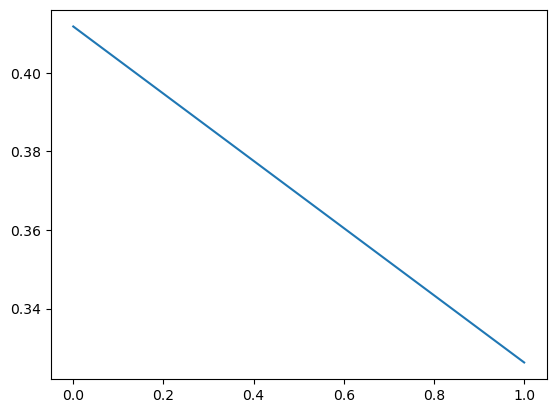

In [53]:
plt.plot(preprocessor.sklearn_block.explained_variance_ratio_)

### 2. Define the output scaler for the output fields (MinMaxScaler + PCA)

In [54]:
postprocessor = Pipeline(
    [
        ("scaler", WrappedSklearnTransform(MinMaxScaler(), in_keys=["field::output_field"])),
        ("pca", WrappedSklearnTransform(PCA(n_components=9), in_keys=["field::output_field"])),
    ]
)
postprocessor

self.input_scalars=[]
self.input_fields=['output_field']
self.output_scalars=[]
self.output_fields=[]
self.input_scalars=[]
self.input_fields=['output_field']
self.output_scalars=[]
self.output_fields=[]


,steps,"[('scaler', ...), ('pca', ...)]"
,transform_input,None
,memory,None
,verbose,False
,sklearn_block,MinMaxScaler()
,fit_only_ones,True
,in_keys,['field::output_field']
,out_keys,[]
,feature_range,"(0, ...)"
,copy,True
,clip,False


In [55]:
postprocessor.fit(dset)

=== In <_extract_X_y_from_plaid> of self.sklearn_block=MinMaxScaler()
self.input_scalars=[]
self.input_fields=['output_field']
self.output_scalars=[]
self.output_fields=[]
type(X)=<class 'list'>
len(X)=1
self.input_scalars=[]
self.input_fields=['output_field']
self.output_scalars=[]
self.output_fields=[]
type(y)=<class 'list'>
len(y)=0
=== In <_extract_X_y_from_plaid> of self.sklearn_block=MinMaxScaler()
self.input_scalars=[]
self.input_fields=['output_field']
self.output_scalars=[]
self.output_fields=[]
type(X)=<class 'list'>
len(X)=1
self.input_scalars=[]
self.input_fields=['output_field']
self.output_scalars=[]
self.output_fields=[]
type(y)=<class 'list'>
len(y)=0
=== In <_extract_X_y_from_plaid> of self.sklearn_block=PCA(n_components=9)
self.input_scalars=[]
self.input_fields=['output_field']
self.output_scalars=[]
self.output_fields=[]
type(X)=<class 'list'>
len(X)=1
self.input_scalars=[]
self.input_fields=['output_field']
self.output_scalars=[]
self.output_fields=[]
type(y)=<clas

,steps,"[('scaler', ...), ('pca', ...)]"
,transform_input,None
,memory,None
,verbose,False
,sklearn_block,MinMaxScaler()
,fit_only_ones,True
,in_keys,['field::output_field']
,out_keys,[]
,feature_range,"(0, ...)"
,copy,True
,clip,False


### 3. Define the regressor

Y = GP(transformer(X)) where transformer(X) = postprocessor(X)

In [56]:
regressor = TransformedTargetRegressor(
    regressor=WrappedSklearnRegressor(
            GaussianProcessRegressor(n_restarts_optimizer=3),
            in_keys=[f"scalar::input_scalar_{scalar_id}" for scalar_id in range(NB_INPUT_SCALARS)],
            out_keys=["field::output_field", *[f"scalar::output_scalar_{scalar_id}" for scalar_id in range(NB_OUTPUT_SCALARS)]],
        ),
    check_inverse=False,
    transformer=postprocessor,
)
regressor

self.input_scalars=['input_scalar_0', 'input_scalar_1', 'input_scalar_2']
self.input_fields=[]
self.output_scalars=['output_scalar_0', 'output_scalar_1', 'output_scalar_2', 'output_scalar_3', 'output_scalar_4']
self.output_fields=['output_field']


,regressor,WrappedSklear..._optimizer=3))
,transformer,Pipeline(step...ponents=9)))])
,func,None
,inverse_func,None
,check_inverse,False
,kernel,None
,alpha,1e-10
,optimizer,'fmin_l_bfgs_b'
,n_restarts_optimizer,3
,normalize_y,False
,copy_X_train,True


### 4. Combine to make the pipeline

In [57]:
model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("scaler", WrappedSklearnTransform(StandardScaler(), in_keys=[f"scalar::input_scalar_{scalar_id}" for scalar_id in range(NB_INPUT_SCALARS)])),
        ("regressor", regressor),
    ]
)
model

self.input_scalars=['input_scalar_0', 'input_scalar_1', 'input_scalar_2']
self.input_fields=[]
self.output_scalars=[]
self.output_fields=[]


,steps,"[('preprocessor', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,sklearn_block,PCA(n_components=2)
,fit_only_ones,True
,in_keys,"['scalar::input_scalar_0', 'scalar::input_scalar_1', ...]"
,out_keys,[]
,n_components,2
,copy,True
,whiten,False


## Fit the model

In [58]:
model.fit(dset)
model

=== In <_extract_X_y_from_plaid> of self.sklearn_block=PCA(n_components=2)
self.input_scalars=['input_scalar_0', 'input_scalar_1', 'input_scalar_2']
self.input_fields=[]
self.output_scalars=[]
self.output_fields=[]
type(X)=<class 'list'>
len(X)=3
self.input_scalars=['input_scalar_0', 'input_scalar_1', 'input_scalar_2']
self.input_fields=[]
self.output_scalars=[]
self.output_fields=[]
type(y)=<class 'list'>
len(y)=0
=== In <_extract_X_y_from_plaid> of self.sklearn_block=StandardScaler()
self.input_scalars=['input_scalar_0', 'input_scalar_1', 'input_scalar_2']
self.input_fields=[]
self.output_scalars=[]
self.output_fields=[]
type(X)=<class 'list'>
len(X)=3
self.input_scalars=['input_scalar_0', 'input_scalar_1', 'input_scalar_2']
self.input_fields=[]
self.output_scalars=[]
self.output_fields=[]
type(y)=<class 'list'>
len(y)=0
=== In <_extract_X_y_from_plaid> of self.sklearn_block=StandardScaler()
self.input_scalars=['input_scalar_0', 'input_scalar_1', 'input_scalar_2']
self.input_fields=[

ValueError: This TransformedTargetRegressor estimator requires y to be passed, but the target y is None.

## Predict on the training data

In [ ]:
y_pred = model.predict(X)

## Other way to define the pipeline

### 1. Define the regressor

In [59]:
regressor = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("scaler", WrappedSklearnTransform(
                        StandardScaler(),
                        in_keys=[f"scalar::input_scalar_{scalar_id}" for scalar_id in range(NB_INPUT_SCALARS)],
                    )),
        ("regressor", WrappedSklearnRegressor(
                            GaussianProcessRegressor(n_restarts_optimizer=3),
                            in_keys=[f"scalar::input_scalar_{scalar_id}" for scalar_id in range(NB_INPUT_SCALARS)],
                            out_keys=["field::output_field", *[f"scalar::output_scalar_{scalar_id}" for scalar_id in range(NB_OUTPUT_SCALARS)]],
                        )),
    ]
)
regressor

self.input_scalars=['input_scalar_0', 'input_scalar_1', 'input_scalar_2']
self.input_fields=[]
self.output_scalars=[]
self.output_fields=[]
self.input_scalars=['input_scalar_0', 'input_scalar_1', 'input_scalar_2']
self.input_fields=[]
self.output_scalars=['output_scalar_0', 'output_scalar_1', 'output_scalar_2', 'output_scalar_3', 'output_scalar_4']
self.output_fields=['output_field']


,steps,"[('preprocessor', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,sklearn_block,PCA(n_components=2)
,fit_only_ones,True
,in_keys,"['scalar::input_scalar_0', 'scalar::input_scalar_1', ...]"
,out_keys,[]
,n_components,2
,copy,True
,whiten,False


### 2. Combine to make the pipeline

In [60]:
model = TransformedTargetRegressor(
    regressor=regressor,
    check_inverse=False,
    transformer=postprocessor,
)
model

,regressor,Pipeline(step...timizer=3)))])
,transformer,Pipeline(step...ponents=9)))])
,func,None
,inverse_func,None
,check_inverse,False
,sklearn_block,PCA(n_components=2)
,fit_only_ones,True
,in_keys,"['scalar::input_scalar_0', 'scalar::input_scalar_1', ...]"
,out_keys,[]
,n_components,2
,copy,True


In [61]:
model.fit(X,y)

self.input_scalars=[]
self.input_fields=['output_field']
self.output_scalars=[]
self.output_fields=[]
self.input_scalars=[]
self.input_fields=['output_field']
self.output_scalars=[]
self.output_fields=[]


AttributeError: 'numpy.ndarray' object has no attribute 'get_fields_to_tabular'